In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os, glob
import dask

In [2]:
def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    return xa

def gmean(da,la,g=[],cf=None,u=None):
    '''
    g defines the averaging group,
    g=[] is global, otherwise use ds.biome or ds.pft
    '''
    if len(g)==0:
        g=xr.DataArray(np.tile('global',len(da.gridcell)),dims='gridcell')
    if not cf:
        cf=1/la.groupby(g).sum()
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        x=cf*(da*la).groupby(g).sum()
    x.name=da.name
    x.attrs=da.attrs
    if u:
        x.attrs['units']=u
    if 'group' in x.dims:
        x=x.isel(group=0)
    if len(x.dims)>0:
        if x.dims[0]!='ens':
            x=x.T  
    
    return x.compute()

In [10]:
in_file = '/glade/derecho/scratch/linnia/ctsm5.3.0_transient_AD/run/ctsm5.3.0_transient_AD.clm2.h0.0021-01-01-00000.nc'
ds = xr.open_dataset(in_file)

In [5]:
la_file = '/glade/u/home/djk2120/clm5ppe/pyth/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

In [6]:
EcoC = gmean(ds.TOTECOSYSC,la)
soilC1m = gmean(ds.TOTSOMC_1m,la)
soilC = gmean(ds.TOTSOMC,la)

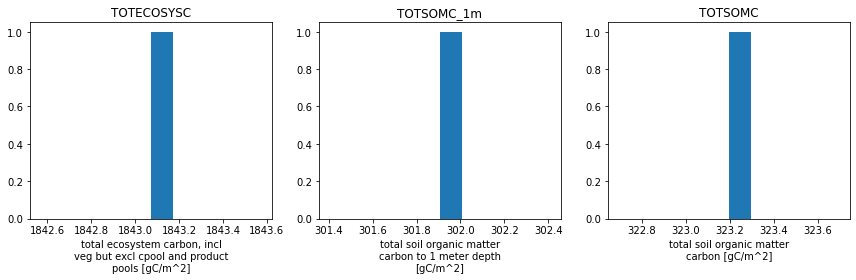

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
EcoC.plot()
plt.title('TOTECOSYSC')

plt.subplot(1,3,2)
soilC1m.plot()
plt.title('TOTSOMC_1m')

plt.subplot(1,3,3)
soilC.plot()
plt.title('TOTSOMC')

plt.tight_layout()